### A notebook to handle figures for the (revisions of) the yoder et al. 2016 Global/Nepal ETAS paper.

The objective is a one-stop, run this script and get all your data sets and figures, shopping center. some of the scripts, however, are HUGE. global etas will take a solid 10-30 hours on 8 cores, and the production script (with expanded ranges, lower mcs, etc) might be longer. the geospatial_roc script may be similar -- a full day to run though 625 nepal_etas configurations.

accordingly, big jobs are blocked with 'if_really_do_this' booleans. to really run this, soup to nuts, those blocks will need to be removed (set to True).

Recommended resources:
 - At least 4 (virtual) cores (aka, i5, i7 processors)
 - At least 16 GB RAM. Global ETAS tends to pull ~8-10 GB (depends a bit on what else is running); the subsequent ROC script can easily boost the total RAM consumption to ~13 GB. It may be possible to run these scripts in less memory by breaking them up ouside of the notebook environment.
 - Also, consider closing non-essential web browser windows/tabs, as they can pull a fair bit of memory.

In [2]:
#
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import datetime as dtm
import matplotlib.dates as mpd
import pytz

import math
import random
import numpy
import scipy
import scipy.optimize as spo
from scipy import interpolate
import itertools
import sys
#import scipy.optimize as spo
import os
import operator
#from PIL import Image as ipp
import multiprocessing as mpp
#
import matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mpd
from mpl_toolkits.mplot3d import Axes3D
import json
import pickle
#
import geopy.distance
from geopy.distance import vincenty
from geopy.distance import great_circle
#
#import shapely.geometry as sgp
#
from mpl_toolkits.basemap import Basemap as Basemap
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from geographiclib.geodesic import Geodesic as ggp
#
#import ANSStools as atp
from yodiipy import ANSStools as atp
#
import contours2kml
import globalETAS as gep
from eq_params import *
#
from nepal_figs import *
import nepal_figs
import optimizers
#
import random

#
tzutc = pytz.timezone('UTC')
#
emc = {'lat':32.13, 'lon':-115.30, 'event_date':dtm.datetime(2010,4,4,22,40,41, tzinfo=pytz.timezone('UTC'))}
nepal_epi_lon = 84.698
nepal_epi_lat = 28.175
#
# huh?
#nepal_tms = dtm.datetime(2015, 4, 26, 7, 5, 19 ,tzinfo=pytz.timezone('UTC'))
#  April 25, 2015 at 06:11:26 UTC
nepal_tms = dtm.datetime(2015,4,25,6,11,26, tzinfo=pytz.timezone('UTC'))

#
# set up dict objects for different earthquakes. maybe from eq_params.py ?
param_keys = ['lat_center', 'lon_center', 'to_dt', 'mc', 'mc_auto', 'cat_len_plus']
# what exactly do we use these for?
nepal_params = {key:val for key,val in zip(param_keys, [nepal_epi_lat, nepal_epi_lon, 
                                                        nepal_tms,
                                                        3.0, 4.5, 220])}
emc_params =   {key:val for key,val in zip(param_keys, [emc['lat'], emc['lon'],
                                                      emc['event_date'] + dtm.timedelta(days=5), 2.5, 5.5, 220])}

local_path: 
failed while loading urllib and/or urllib. maybe python 3.x?


### some random geopy bits:
  - easy syntax for great-circle or vincenty (more precise, iterative model) geodetic distances
  - forward and reverse geocoding
  

In [4]:
#

newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(geopy.distance.vincenty(newport_ri, cleveland_oh).miles)
print(geopy.distance.great_circle(newport_ri, cleveland_oh).miles)

from geopy.geocoders import Nominatim
geolocator = Nominatim()
#location = geolocator.geocode("175 5th Avenue NYC")
location = geolocator.geocode("509 S Waiola Ave, La Grange IL")
print(location.address)
print(location.point)

538.3904451566326
537.1485284062816
509, South Waiola Avenue, La Grange, Cook County, Illinois, 60525, United States of America
41 48m 16.8175s N, 87 52m 35.5949s W


### ETAS and ROC figures
  - ETAS map
    - include recent (shortly before forecast date) earthquakes
  - ROC analysis
  
  Also include:
    - ETAS forecast catalog $t<t_0$
    - ETAS test catalog $t>t_0$
    - ETAS data.xyz file
    - Image(s)
    - KML
    - ROC table(s)
  
  For now, copy the make_Nepal_figs from nepal_figs.py. we'll move this to the original, or a new, module when we work out the bugs.

In [14]:
#class nepal__ROC_script(object):
#    def __init__(self, fignum=0, mcs = [4., 5., 6., 7.], n_cpu=None):
fignum=0
mcs = [4., 5., 6., 7.]
n_cpu=None

# full, one stop shopping script for nepal ROC analysis.
#
# first, get nepal ETAS objects:
#etas_fc, etas_test = etas_analyzer.nepal_etas_roc()
#
revisions_data = 'data/revisions_outputs'
if not os.path.isdir(revisions_data): os.makedirs(revisions_data)

### Nepal Forecast(s):

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2010-05-08 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 288], None)
make_etas():
etas_mpp worker xyz_range:  [0, 625]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catle

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2010-04-27 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2010, 4, 27, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 4, 26, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2010, 4, 27, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 4, 26, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 225], None)
make_etas():
etas_mpp worker xyz_range:  [0, 1428]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - 

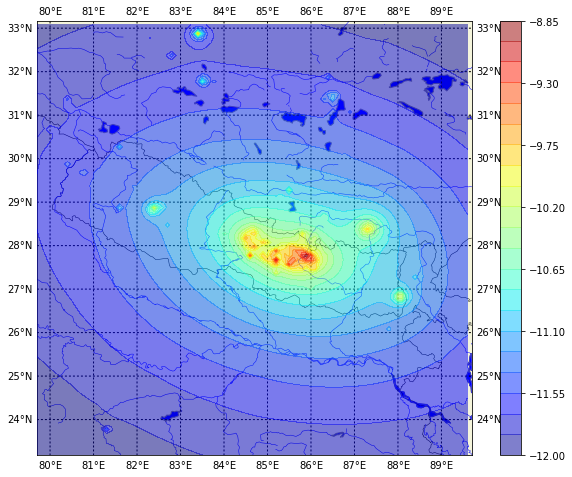

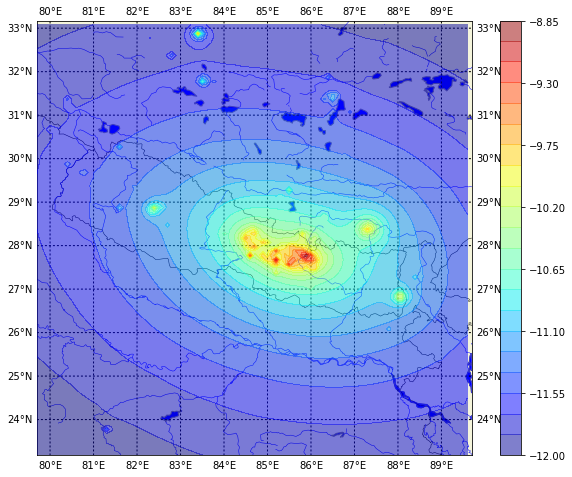

In [33]:
# TODO: code up something to load at least the salient bits from an export file.
#


#
calc_nepal_etas = True
pkl_nepal_etas = True
#load_nepal_etas_pkl = True
load_nepal_etas_pkl = False
#
pkl_nepal_etas_path='gorkha_data'
nepal_etas_fc_fname   = 'nepal_etas_fc.pkl'
nepal_etas_test_fname = 'nepal_etas_test.pkl'
#
# filenames to load a pickled object:
nepal_etas_fc_fname_in   = nepal_etas_fc_fname
nepal_etas_test_fname_in = nepal_etas_test_fname
#
if calc_nepal_etas:
    nepal_etas_fc = etas_analyzer.get_nepal_etas_fc(n_cpu=2*mpp.cpu_count())
    #plt.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))
    #
    # note, nepal_etas_test does not calc. etas, but we'll want etas do to the geospatial bit.
    nepal_etas_test = etas_analyzer.get_nepal_etas_test(n_cpu=2*mpp.cpu_count())
    nepal_etas_test.make_etas()
    #plt.savefig(os.path.join(revisions_data, 'nepal_test_etas_contours.png'))
    if pkl_nepal_etas:
        if not os.path.isdir(pkl_nepal_etas_path):
            os.makedirs(pkl_nepal_etas_path)
        #
        with open(os.path.join(pkl_nepal_etas_path, nepal_etas_fc_fname), 'wb') as fout_fc:
            pickle.dump(nepal_etas_fc, fout_fc)
        with open(os.path.join(pkl_nepal_etas_path, nepal_etas_test_fname), 'wb') as fout_fc:
            pickle.dump(nepal_etas_test, fout_fc)
    #
    # maybe we'll also load up one or more global forecasts as well?
if load_nepal_etas_pkl:
    with open(nepal_etas_fc_fname, 'rb') as fin:
        nepal_etas_fc = pickle.load(fin)
    with open(nepal_etas_test_fname, 'rb') as fin:
        nepal_etas_test = pickle.load(fin)

if True:
    fg = plt.figure(1, figsize=(10,8))
    plt.clf()
    lons_map = None
    lats_map = None
    #lons_map = [84., 87.]
    #lats_map = [27., 29.]
    cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=1, fig_size=(10,8), n_contours=25,
                                                lons_map=lons_map,lats_map=lats_map)
    #cm_fc.scatter(*zip(*[[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog if rw['mag']>5.]), marker='.',latlon=True )
    # ... not the way to do this...
    #ax=plt.gca()
    #ax.set_xlim([83.,88.])
    #ax.set_ylim([27., 29.5])
    fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))
    #
    # # get an 'initial' forecast:
    neapl_etas_initial = etas_analyzer.get_nepal_etas_fc(n_procs=2*mpp.cpu_count(), cat_len=5.*365., p_cat=1.1,
                                                         q_cat=1.5, t_0 = dtm.datetime(1990,1,1, tzinfo=tz_utc),
                                                         t_now=dtm.datetime(2015,4,26, tzinfo=tzutc))
    fg = plt.figure(2,figsize=(10,8))
    plt.clf()
    lons_map = None
    lats_map = None
    #lons_map = [84., 87.]
    #lats_map = [27., 29.]
    # note: we'll make a zoomed version of this and save it down-stream a bit.
    cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=2, fig_size=(10,8), n_contours=25,
                                                    lons_map=lons_map,lats_map=lats_map)

In [84]:
fg = plt.figure(1, figsize=(10,8))
plt.clf()
lons_map = None
lats_map = None
#lons_map = [84., 87.]
#lats_map = [27., 29.]
cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=1, fig_size=(10,8), n_contours=25,
                                            lons_map=lons_map,lats_map=lats_map, cmap_map='jet')
#cm_fc.scatter(*zip(*[[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog if rw['mag']>5.]), marker='.',latlon=True )
# ... not the way to do this...
#ax=plt.gca()
#ax.set_xlim([83.,88.])
#ax.set_ylim([27., 29.5])
fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours.png'))

NameError: name 'nepal_etas_fc' is not defined

#### Gorkha, Nepal forecast map, up close and with the post-mainshock, pre 12 May, aftershocks plotted (for doubters)

In [35]:
print(nepal_etas_fc.catalog[0]['event_date'], nepal_tms, nepal_etas_fc.catalog[-1]['event_date'])
print(nepal_etas_fc.catalog.dtype.names)
#plt.figure()
#plt.plot(nepal_etas_fc.catalog['event_date'], nepal_etas_fc.catalog['mag'])

2010-06-02T08:05:22.880000 2015-04-25 06:11:26+00:00 2015-05-06T21:56:28.670000
('event_date', 'lat', 'lon', 'mag', 'depth', 'event_date_float', 'L_r', 'r_0', 'chi', 'dt_r', 't_0', 'tau', 'dmstar', 'p', 'q', 'e_vals', 'e_vecs', 'N_eig_cat')


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:22: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:24: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3

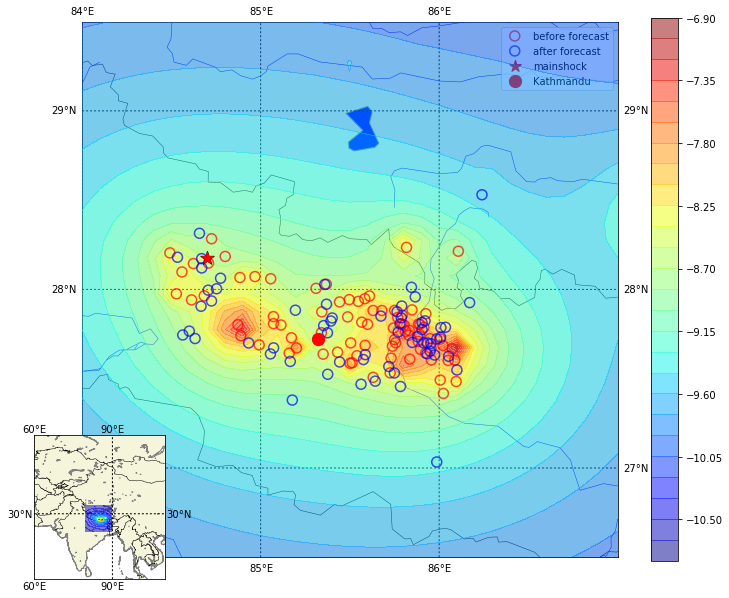

In [36]:
fg = plt.figure(1, figsize=(12,10))
plt.clf()
#lons_map = None
#lats_map = None
lons_map = [84., 87.]
lats_map = [26.5, 29.5]
fnum=1
fg=plt.figure(fnum)
# use initial forecast:
# # # get an 'initial' forecast:
#cm_fc = nepal_etas_fc.make_etas_contour_map(fignum=1, fig_size=(10,8), n_contours=25, lons_map=lons_map,lats_map=lats_map)
cm_fc = neapl_etas_initial.make_etas_contour_map(fignum=fnum, fig_size=(10,8), n_contours=25, lons_map=lons_map,
                                                 lats_map=lats_map)
ax=plt.gca()
#
# two catalogs:
# sub_cat1: events included in the forecast; after mainshock, but before fc_date
# sub_cat2: events after the forecast but before the large aftershocks.
dt_split = dtm.datetime(2015,4,26,tzinfo=pytz.timezone('UTC'))
sub_cat1 = [[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(nepal_tms)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dt_split))]
sub_cat2 = [[rw['lon'], rw['lat']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(dt_split)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dtm.datetime(2015,5,12,tzinfo=pytz.timezone('UTC'))))]

# note, with "scatter()", we should be able to easily size the elements by magnitude, color them by time, etc. if we want.
cm_fc.scatter(*zip(*sub_cat1),
              marker='o', edgecolors='r', facecolors='none', linewidths=1.5,
              s=100, alpha=.7, latlon=True, zorder=10, label='before forecast' )
cm_fc.scatter(*zip(*sub_cat2),
              marker='o', edgecolors='b', facecolors='none', linewidths=1.5,
              s=100, alpha=.7, latlon=True, zorder=10, label='after forecast')

cm_fc.scatter(*cm_fc(nepal_epi_lon, nepal_epi_lat), marker='*', s=150, color='r', 
              latlon=False, zorder=12, label='mainshock')
cm_fc.scatter(*cm_fc(nepal_epi_lon, nepal_epi_lat), marker='*', s=195, color='k', latlon=False, zorder=11)
#
# and kathmandu:
# 27.7172° N, 85.3240° E
cm_fc.scatter(*cm_fc(85.32, 27.72), marker='o', s=150, color='r', 
              latlon=False, zorder=12, label='Kathmandu')

# ... not the way to do this...
#ax=plt.gca()
#ax.set_xlim([83.,88.])
#ax.set_ylim([27., 29.5])

#ax.legend(loc=0, numpoints=1)
cm_fc.ax.legend(loc=0, numpoints=1)
#cm_fc.legend(loc=0, numpoints=1)

ax_inset = fg.add_axes([.01, .1, .27, .2])
cm_fc = neapl_etas_initial.make_etas_contour_map(ax=ax_inset, fig_size=(10,8), n_contours=25, lons_map=(60,110),
                                                 lats_map=(5,60), lon_interval=30, lat_interval=30, do_colorbar=False,
                                                do_states=False, do_rivers=False, lake_color=None)


#fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_contours_closeup_with_eqs.png'))

fg.savefig(os.path.join(revisions_data, 'nepal_fc_initial_etas_contours_closeup_with_eqs.png'))

In [37]:
print('revs: ', revisions_data)

revs:  data/revisions_outputs


/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
/home/myoder/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


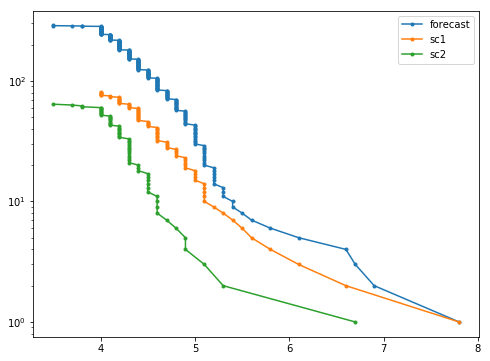

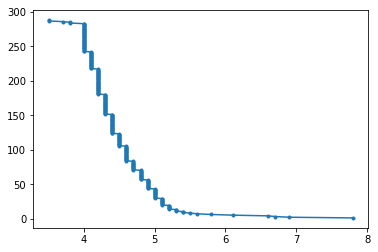

In [38]:
### GR dists of before and after catalogs

sc1 = [[rw['lon'], rw['lat'], rw['mag']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(nepal_tms)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dt_split))]
sc2 = [[rw['lon'], rw['lat'], rw['mag']] for rw in nepal_etas_fc.catalog 
                     if (rw['mag']>3. and numpy.datetime64(rw['event_date'])>=numpy.datetime64(dt_split)
                   and numpy.datetime64(rw['event_date'])<numpy.datetime64(dtm.datetime(2015,5,12,tzinfo=pytz.timezone('UTC'))))]


plt.figure(figsize=(8,6))
plt.clf()
ax=plt.gca()
ax.set_yscale('log')
ax.plot(sorted(nepal_etas_fc.catalog['mag']), len(nepal_etas_fc.catalog) - numpy.arange(len(nepal_etas_fc.catalog)), '.-', label='forecast')
ax.plot(sorted([m for x,y,m in sc1]), len(sc1)-numpy.arange(len(sc1)), '.-', label='sc1')
ax.plot(sorted([m for x,y,m in sc2]), len(sc2)-numpy.arange(len(sc2)), '.-', label='sc2')

ax.legend(loc=0)

plt.figure()
N = len(nepal_etas_fc.catalog)
plt.plot(sorted(nepal_etas_fc.catalog['mag']), N + 1 - numpy.arange(1, len(nepal_etas_fc.catalog)+1), '.-')




/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


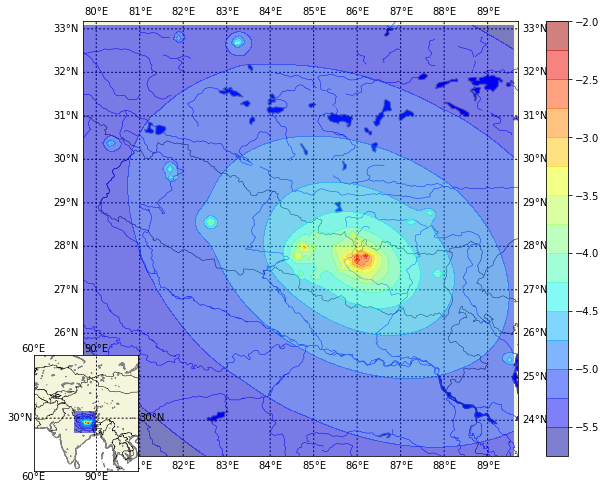

In [39]:
# Nepal "test" catalog: events following the forecast (7 May + 120 days.)
#
fg=plt.figure(2, figsize=(10,8))
plt.clf()
cm_test = nepal_etas_test.make_etas_contour_map(fignum=2, fig_size=(10,8))
#
# draw an inset to show location:
ax_inset = fg.add_axes([.01, .1, .27, .2])
cm_fc = neapl_etas_initial.make_etas_contour_map(ax=ax_inset, fig_size=(10,8), n_contours=25,
                                                 lons_map=(60,110), lats_map=(5,60), lon_interval=30,
                                                 lat_interval=30, do_colorbar=False,
                                                do_states=False, do_rivers=False, lake_color=None)
ax.set_title('Gorkha Test ETAS (7 May + 120 days)\n')
#
fg.savefig(os.path.join(revisions_data, 'nepal_test_etas_contours.png'))

In [40]:
print(min(nepal_etas_test.catalog['event_date']))
print(max(nepal_etas_test.catalog['event_date']))
#
print('max/min fc: ', min(nepal_etas_fc.catalog['event_date']), max(nepal_etas_fc.catalog['event_date']))

2015-05-08T00:32:33.960000
2015-09-01T23:06:40.640000
max/min fc:  2010-06-02T08:05:22.880000 2015-05-06T21:56:28.670000


In [43]:
etas_test.catalog.dtype

dtype((numpy.record, [('event_date', '<M8[us]'), ('lat', '<f8'), ('lon', '<f8'), ('mag', '<f8'), ('depth', '<f8'), ('event_date_float', '<f8'), ('L_r', '<f8'), ('r_0', '<f8'), ('chi', '<f8'), ('dt_r', '<f8'), ('t_0', '<f8'), ('tau', '<f8'), ('dmstar', '<f8'), ('p', '<f8'), ('q', '<f8'), ('e_vals', '>f8', (2,)), ('e_vecs', '>f8', (2, 2)), ('N_eig_cat', '>f8')]))

#### ROC figures for Nepal:

ROC for mc=4.0
len(xyz_ev):  142
ROC for mc=5.0
len(xyz_ev):  12
ROC for mc=6.0
len(xyz_ev):  2
ROC for mc=7.0
len(xyz_ev):  1


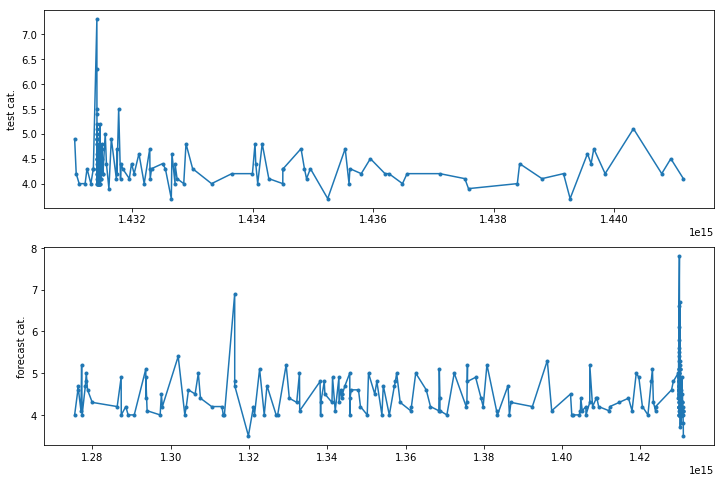

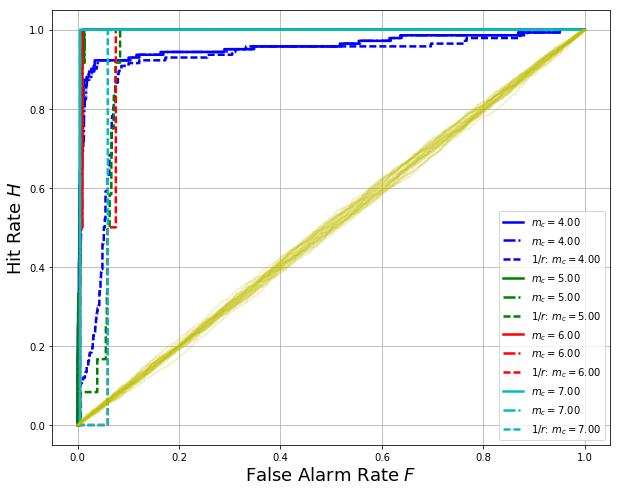

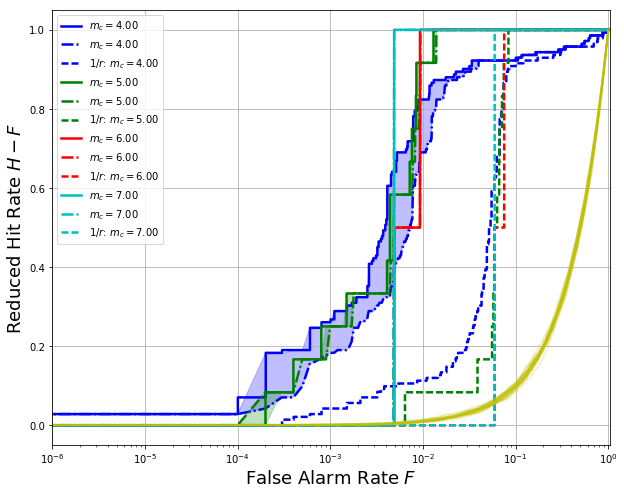

In [45]:
# designate ETAS class instances:
#
etas_test = nepal_etas_test
test_catalog = etas_test.catalog
etas_fc = nepal_etas_fc
#
# do a quick time-series plot from each catalog (just to be sure)
fg=plt.figure(figsize=(12,5))
ax1 = plt.subplot('111')
#ax2 = plt.subplot('212')
t_0_roc = mpd.date2num(etas_fc.catalog['event_date'][-1].astype(dtm.datetime))
ax1.plot(etas_test.catalog['event_date'], etas_test.catalog['mag'], marker='.', ls='-', label='test')
ax1.plot(etas_fc.catalog['event_date'],   etas_fc.catalog['mag'], marker='.', ls='-', label='forecast')
#ax1.set_ylabel('test cat.')
#ax2.set_ylabel('forecast cat.')
ax1.set_ylabel('magnitude $m$')
#

x0 = nepal_epi_lon
y0 = nepal_epi_lat
null_dist_expon = 1.5     # exponent for null model, aka aftershocks fall off like 1/r**null_dist_expon
#
mag=7.8
L_r = .5*10**(.5*mag - 1.76)
xyz = etas_fc.ETAS_array
# make a null mode with z ~ 1/r. we'll probably need a contour figure of this.
xyz_null = [[x,y,((L_r + geopy.distance.great_circle((y,x), (y0,x0)).km)**(-null_dist_expon))] for x,y,z in xyz]
xyz_null_1 = [[x,y,((L_r + geopy.distance.great_circle((y,x), (y0,x0)).km)**(-1.))] for x,y,z in xyz]
xyz_events = list(zip(test_catalog['lon'], test_catalog['lat'], test_catalog['mag']))
#
# now, replace all of this m"get x,y and ROC" stuff with the optimizers.roc_tools equivalents.
#roc_xyz_handler = optimizers.ROC_xyz_handler(xyz, list(zip(test_catalog['lon'], test_catalog['lat'], test_catalog['mag'])),
#                                            z_event_min=None)
#
#ROC_handler = ROC_xyz_handler(xyz, xyz_events, z_event_min=None)
#
#fg1=plt.figure(fignum, figsize=(10,8))
fg1=plt.figure(figsize=(10,8))
plt.clf()
ax1=plt.gca()
ax1.set_xscale('linear')
#
#fg2=plt.figure(fignum+1, figsize=(10,8))
fg2=plt.figure(figsize=(10,8))
plt.clf()
ax2=plt.gca()
ax2.set_xscale('log')

FHs = {}        # we'll use mc as a key, FH as a val: {mc:[FH]...}
for j,mc in enumerate(mcs):
    clr = colors_[j%len(colors_)]
    print('ROC for mc={}'.format(mc))
    #
    # there's a faster way to do this...
    xyz_ev = [[x,y,z] for x,y,z in xyz_events if z>=mc]
    print("len(xyz_ev): ", len(xyz_ev))
    ROC_real = optimizers.roc_tools.ROC_xyz_handler(xyz,      xyz_events, z_event_min=mc)
    ROC_null = optimizers.roc_tools.ROC_xyz_handler(xyz_null, xyz_events, z_event_min=mc)
    #ROC_null_1 = optimizers.roc_tools.ROC_xyz_handler(xyz_null_1, xyz_events, z_event_min=mc)
    #
    #events = [z for x,y,z in ROC_handler if z>=mc]
    # calc_roc(Z_fc=self.z_fc, Z_ev=self.z_events
    FH      = ROC_real.calc_roc()
    FH_molc = ROC_real.calc_molchan()
    FH_null = ROC_null.calc_roc()
    #
    #print('FH_molc: ', FH_molc[-5:])
    #
    # set up an interpolation object so we can do a fill_between() the ROC and Molchan
    f_interp_roc = interpolate.interp1d(*zip(*(list(FH) + [[1.,1.]])))
    f_interp_mol = interpolate.interp1d(*zip(*(list(FH_molc) + [[1.,1.]])))
    x_interp = numpy.linspace(0., 1.,10000)
    #
    y_roc = f_interp_roc(x_interp)
    y_mol = f_interp_mol(x_interp)
    ax1.fill_between(x_interp, y_roc, y_mol, color=clr, alpha=.25)
    
    #x_interp_log = numpy.array([10**x for x in numpy.linspace(min(numpy.log([x for x,y in FH])), 
    #                                                          max(numpy.log([x for x,y in FH])),1000)])
    #f_interp_roc_log=interpolate.interp1d(numpy.log10([x for x,y in FH]), [y for x,y in FH])
    #f_interp_mol_log=interpolate.interp1d(numpy.log10([x for x,y in FH]), [y for x,y in FH_molc])
    ax2.fill_between([1e-6] + list(x_interp), [0.] + list(y_roc), [0.] + list(y_mol), color=clr, alpha=.25)    
    #
    # plot ETAS FH and 'null' (1/r) FH on ax1 (linear)
    ax1.plot(*zip(*FH), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax1.plot(*zip(*FH_molc), ls='-.', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax1.plot(*zip(*FH_null), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    #
    # plot ETAS and null (1/r) FH on ax2 (log)
    #ax2.plot(*zip(*[[f,h-f] for f,h in FH]), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    #ax2.plot(*zip(*[[f,h-f] for f,h in FH_null]), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    ax2.plot(*zip(*FH), ls='-', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    ax2.plot(*zip(*FH_molc), ls='-.', color=clr, marker='', lw=2.5, label='$m_c=%.2f$' % mc)
    #ax2.fill_between([x for x,y in FH], [y for x,y in FH], [y for x,y in FH_molc], color=clr, alpha=.25)
    ax2.plot(*zip(*FH_null), ls='--', color=clr, marker='', lw=2.5, label='$1/r$: $m_c=%.2f$' % mc)
    #
    #
    # now, some random catalogs:

#plt.figure()
#z_min = min([z for x,y,z in xyz])
#z_max = max([z for x,y,z in xyz])
z_len = len(xyz)
for j in range(25):
    # we probably want a better model for this, but if it works, maybe we keep it.
    R = random.Random()
    #xyz_r = [[x,y,xyz[int(z_len*R.random())][2]] for x,y,z in xyz]
    #ROC_rand = optimizers.roc_tools.ROC_xyz_handler(xyz_r, xyz_events, z_event_min=mc)
    #
    fh = optimizers.roc_tools.calc_roc([z for x,y,z in xyz], sorted([z for x,y,z in xyz], key=lambda x: R.random())[0:int(.2*z_len)])
    #
    #this_etas = etas_analyzer.Toy_etas_random(etas_in=etas_fc)
    #FH = etas_analyzer.roc_normal(this_etas, fignum=None)
    ax1.plot(*zip(*fh), marker='', ls='-', alpha=.2, color='y')
    ax2.plot(*zip(*[[f,h] for f,h in fh]), marker='', ls='-', alpha=.2, color='y')
#
#ax1.plot(range(2), range(2), ls='--', color='m', lw=3., alpha=.75, zorder=2)
ax1.plot(*zip(*[[x,x] for x in numpy.arange(0.,1.,1000)]), marker='', ls='--', color='m', lw=2.)
ax2.plot(*zip(*[[x,x] for x in numpy.arange(0.,1.,1000)]), marker='', ls='--', color='m', lw=2.)
#
ax1.set_ylim(-.05, 1.05)
ax1.set_xlim((-.05, 1.05))
ax1.grid()
ax1.legend(loc=0, numpoints=1)
ax1.set_ylabel('Hit Rate $H$', size=18)
ax1.set_xlabel('False Alarm Rate $F$', size=18)
#
ax2.set_ylim(-.05, 1.05)
ax2.set_xlim((-.05, 1.05))
ax2.grid()
ax2.legend(loc=0, numpoints=1)
ax2.set_ylabel('Reduced Hit Rate $H-F$', size=18)
ax2.set_xlabel('False Alarm Rate $F$', size=18)
#self.__dict__.update(locals())
#

#################################################
#################################################
with open(os.path.join(revisions_data, 'nepal_xyz_etas_fc.xyz'), 'w') as f:
    f.write('#x\t\ty\tz\n')
    for rw in xyz:
        f.write('{}\n'.format('\t'.join([str(x) for x in rw])))
#
with open(os.path.join(revisions_data, 'nepal_xyz_etas_fc_nul_exp_135.xyz'), 'w') as f:
    f.write('#x\t\ty\tz\n')
    for rw in xyz:
        f.write('{}\n'.format('\t'.join([str(x) for x in rw])))
#

with open(os.path.join(revisions_data, 'nepal_test_catalog.cat'), 'w') as f:
    etas_test.catalog.tofile(f, sep='\t')
with open(os.path.join(revisions_data, 'nepal_fc_catalog.cat'), 'w') as f:    
    nepal_etas_fc.catalog.tofile(f, sep='\t')

fg1.savefig(os.path.join(revisions_data, 'nepal_roc_lin.png'))
fg2.savefig(os.path.join(revisions_data, 'nepal_roc_log.png'))


#A = nepal__ROC_script()

In [42]:
print(f_interp_mol.x[-5:])
print(f_interp_roc.x[-5:])

[ 0.9996  0.9997  0.9998  0.9999  1.    ]
[ 0.99969997  0.99979998  0.99989999  1.          1.        ]


In [ ]:
# Now, let's write stuff to file:
plt.savefig(os.path.join(revisions_data, 'nepal_roc_figure.png'))


In [24]:
# import global_etas_auto

# aa=global_etas_auto.auto_etas()

# #print(aa)

# #plt.figure(0,figsize=(10,8))
# #ax=plt.gca()
# aa.make_etas_contour_map(fig_size=(10,8), n_contours=25 )
# date_str = str(dtm.datetimen.now())
# plt.title('ETAS, Pacific Islands, {%s}'.format(date_str))
# #
# plt.savefig('data/pacific/pacific_20160729_{}.png'.format(date_str))
# aa.export_xyz('data/pacific/pacific_20160729_{}.xyz'.format(date_str))
# aa.export_kml('data/pacific/pacific_20160729_{}.kml'.format(date_str))

# # ... and eventually write this into globalETAS()
# with open('data/pacific/pacific_cat_20160729_{}.cat'.format(date_str)), 'w') as f:
#     aa.catalog.tofile(f, '\t')

### Global ETAS and ROC
- see nepal_figs.py.global_roc_from_optimizer()


In [30]:
figs_data_path = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs'
xyz_output = os.path.join(figs_data_path, 'global_etas.xyz')
#

In [31]:
# TODO: this needs to be cleaned up. we've tried to accomodate the super data and compute intensive process
# by allowing some pre-calc options, but now it's just complicated... so consolidate.
# 1) get ETAS (either calc or load; there needs to be a to_date in there somewhere; maybe load a picked
#    object.
# 2) get ROC from roc = optimizers.roc_tools.ROC_xyz_handler(xyz,      xyz_events, z_event_min=mc)
#    (see nepal_roc above)
#
# we need to re-code global_etas() to use a Pool() instead of manual process handling. in the mean time, just give it
# more processes than it has processors (then, the small jobs will finish up early, and the multiple-thread overhead
# should be relatively small). the idea is to have all processors running flat out, all the time... and not run out
# of memory.
do_global = False
#do_global = True
t_roc_global = dtm.datetime(2016,4,12, 12,52,59, tzinfo=pytz.timezone('UTC'))
if do_global:
    n_cpu = mpp.cpu_count()*3
    #
    # note: the default behavior for this is to give a forcast date of now-fc_len, and so a forecast validation up to today.
    #
    # TODO: this needs to be un-packaged i think. we should get an ETAS, then an ROC.
    #t_roc_global = dtm.datetime(2015,10,19, tzinfo=pytz.timezone('UTC'))
    glob_etas_roc =  global_etas_and_roc(fc_len=120, fout_xyz=xyz_output, fignum=0, m_cs=[4.0, 5.0, 6.0, 6.5], 
                                         t_now=t_roc_global, n_cpu=n_cpu)
    #

    with open(os.path.join(figs_data_path, 'global_roc_FH.json'), 'w') as f:
        json.dump(glob_etas_roc['roc'],f)

In [52]:
#roc_glob = global_roc_from_optimizer(fc_xyz=etas.ETAS_array, fignum=fignum+1, mcs=6.0,
#fc_len=fc_len, ls=roc_ls, marker=roc_marker, lw=roc_lw)
#
# for this script, we might actually load the headers and body data, so we can re-use the body data
# when we repeadedly run ROC (loading from disk is slow).
# in any case, the open-file bit here is to (nominally, eventually) load header data.
#
# print header data from global eatas output:
# (and if we need to, we can extract the prams from here.)
with open(xyz_output,'r') as f:
    for rw in f:
        if rw[0]=='#':
            print(rw)
        else:
            #
            # and assume 1) it's a long file, 2) all the comments are at the front.
            break
        #
    #
#
   

# do roc starting just after end of etas (be careful trying to make this more/less fair;
#see the global_roc_from_optimizer code.)
#
print('begin roc_glob...')
# should be returning like [[mc, [FH]], [mc, [FH]], ]   # where [FH] implies an array return like [[f,h], [f,h], ... ]
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0,
                                     etas_end_date=t_roc_global,
                                     mcs=[4.,5., 6.0], fc_len=120, ls='-', marker='', lw=2,
                                     x_scale='linear', figsize=(9,8))
# maybe also get some info for the forecast dates into the name?
plt.savefig(os.path.join(figs_data_path, 'roc_global_linear.png'))
plt.savefig(os.path.join(revisions_data, 'roc_global_linear.png'))

#plt.close(0)
#del roc_glob
#
# ax=plt.gca()
# ax.set_xscale('log')
# plt.draw()
# plt.savefig(os.path.join(figs_data_path, 'roc_global_logx.png'))
# plt.savefig(os.path.join(revisions_data, 'roc_global_logx.png'))
#
plt.close(0)
del roc_glob


#global ETAS

#lats=[-89.0, 89.0]	lons=[-180.0, 180.0]	mc=3.0	d_lon=0.1	d_lat=0.1	etas_range_factor=30.0	etas_range_padding=1.0	etas_fit_factor=1.5	t_now=2016-04-12 12:52:59+00:00	cat_len=3650.0

begin roc_glob...
get cataog:  [-180.0, 179.90000000000001] [-89.0, 88.900000000000006] 4.0 2016-04-12 12:52:59+00:00 2016-08-10 12:52:59+00:00
data handle fetched...
 no file.
catlen:  4604


In [53]:
# and one for log_x:
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0,
                                      etas_end_date=dtm.datetime(2016,4,12, 12,52,59, tzinfo=pytz.timezone('UTC')),
                                      mcs=[4.,5., 6.0], fc_len=120, ls='-', marker='', lw=2, x_scale='log')
# maybe also get some info for the forecast dates into the name?
plt.savefig(os.path.join(figs_data_path, 'roc_global_logx.png'))
plt.savefig(os.path.join(revisions_data, 'roc_global_logx.png'))

plt.close(0)
#del roc_glob

print('finished with roc_glob...')

get cataog:  [-180.0, 179.90000000000001] [-89.0, 88.900000000000006] 4.0 2016-04-12 12:52:59+00:00 2016-08-10 12:52:59+00:00
data handle fetched...
 no file.
catlen:  4604
finished with roc_glob...


In [54]:
## Diagnostic
# print(len(roc_glob))

# sums = optimizers.roc_tools.integrate_fh([rw[-1][0:1000000] for rw in roc_glob], n_cpu=2)
# print('sums: ', sums)

# print(optimizers.roc_tools.integrate_fh(roc_glob[0][-1]))
# print(optimizers.roc_tools.integrate_fh(roc_glob[2][-1]))

In [55]:
# TODO: write this into roc_tools.py.
# make a single call that nests the spp and mpp versions; maybe also add some code to discriminate
# leading meta-data in a row, so we can pass [[x1,x2,..., FH], ...]
# ### see optimizers.roc_tools.py for working integrate_fh(). this version will take FH, [FH, FH, FH]
# and handles mpp as well... but be careful with it, since it can be memory intensive.

# def integrate_fh(FH, skill=True):
#     f_factor=skill%2    # integrate skill score (h-f) or h score
#     #
#     # do simple block integration; err on the side of a higher score.
#     return numpy.sum([(h-f_factor*f)*(f-FH[j][0]) for j, (f,h) in enumerate(FH[1:])])

# n_cpu = None
# n_cpu = 3
# n_cpu = (n_cpu or mpp.cpu_count())

# # note: i think these global ROC bits are about 2GB each...

# if n_cpu>1:
#     P = mpp.Pool(mpp.cpu_count())
#     res=[]
#     outputs = []
#     for mc, fh in roc_glob:
#         #print('score:', mc, integrate_fh(fh))
#         res += [[mc, P.apply_async(integrate_fh, args=(fh,True))]]
#     P.close()
#     P.join()
#     for mc, r in res:
#         outputs += [[mc, r.get()]]
#         print('mc: {}::{}'.format(mc, outputs[-1][1]))
# else:
#     for mc,fh in roc_glob:
#         print('score: {} :: {}'.format(mc, integrate_fh(fh)))
#     #

outputs = optimizers.roc_tools.integrate_fh([rw[-1] for rw in roc_glob], n_cpu=1)

working... (this might take a while)...


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


cmap:  hot
finishd.


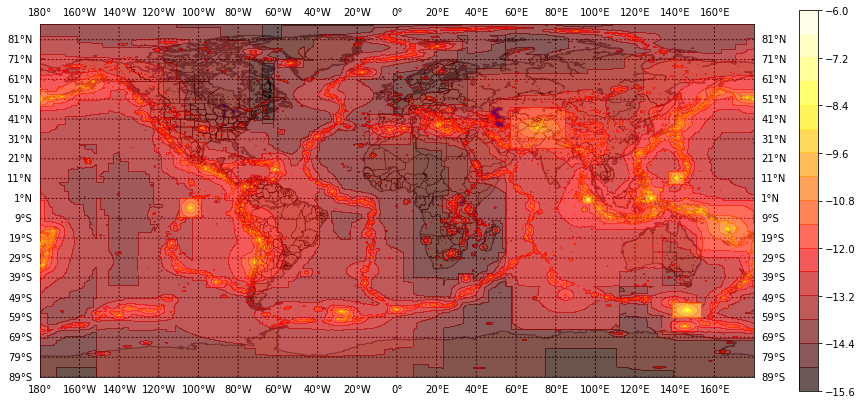

In [33]:


plt.figure(0, figsize=(16,14))
print('working... (this might take a while)...')
# nepal_figs.
CC = draw_global_etas_contours(xyz=xyz_output, fignum=0, cmap='hot')
plt.colorbar(shrink=.5)

print('working file: {}'.format(xyz_output))
#
# get header data:
header_data=''
with open(xyz_output, 'r') as fin:
    for rw in fin:
        if rw.startswith('#'):
            #rw.replace('\n', '\t')
            header_data = header_data + rw.replace('\n', '\t')[1:]
        else:
            break
    #header_data = header_data + fin.readline()
#
header_datas = header_data.split('\t')
#header_datas = {key:val for key,val in rw.split('=') for rw in header_datas}
header_datas = dict([rw.split('=') for rw in header_datas[2:] if len(rw.split('='))>=2])
#
plt.title('Global ETAS: t={}, $m_c={:.1f}$\n\n'.format(header_datas['t_now'], float(header_datas['mc'])))

print('hd: ', header_datas)

print('finishd.')


plt.savefig(os.path.join(revisions_data, 'global_etas_map_hot.png'))

print(xyz_output)

working... (this might take a while)...


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


cmap:  jet
working file: /home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/global_etas.xyz
hd:  {'lons': '[-180.0, 180.0]', 'mc': '3.0', 'd_lon': '0.1', 'd_lat': '0.1', 'etas_range_factor': '30.0', 'etas_range_padding': '1.0', 'etas_fit_factor': '1.5', 't_now': '2016-04-12 12:52:59+00:00', 'cat_len': '3650.0'}
finishd.


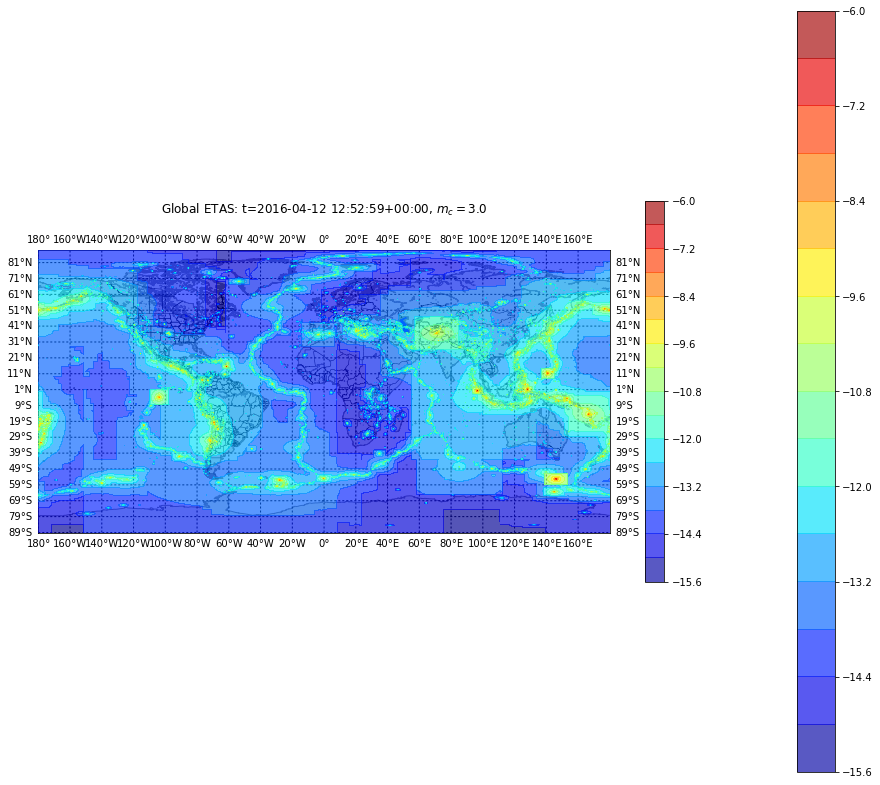

In [73]:
plt.figure(0, figsize=(16,14))
print('working... (this might take a while)...')
# nepal_figs.
# cmap_str='spectral'
cmap_str = 'jet'
CC = draw_global_etas_contours(xyz=xyz_output, fignum=0, cmap=cmap_str)
plt.colorbar(shrink=.5)
#
print('working file: {}'.format(xyz_output))
#
# get header data:
header_data=''
with open(xyz_output, 'r') as fin:
    for rw in fin:
        if rw.startswith('#'):
            #rw.replace('\n', '\t')
            header_data = header_data + rw.replace('\n', '\t')[1:]
        else:
            break
    #header_data = header_data + fin.readline()
#
header_datas = header_data.split('\t')
#header_datas = {key:val for key,val in rw.split('=') for rw in header_datas}
header_datas = dict([rw.split('=') for rw in header_datas[2:] if len(rw.split('='))>=2])
plt.title('Global ETAS: t={}, $m_c={:.1f}$\n\n'.format(header_datas['t_now'], float(header_datas['mc'])))
#
plt.savefig(os.path.join(revisions_data, 'global_etas_map_{}.png'.format(cmap_str)))

print('hd: ', header_datas)
          
print('finishd.')
#



get cataog:  [-180.0, 179.90000000000001] [-89.0, 88.900000000000006] 4.0 2016-04-12 13:00:00+00:00 2016-08-10 13:00:00+00:00
data handle fetched...
 no file.
catlen:  4604


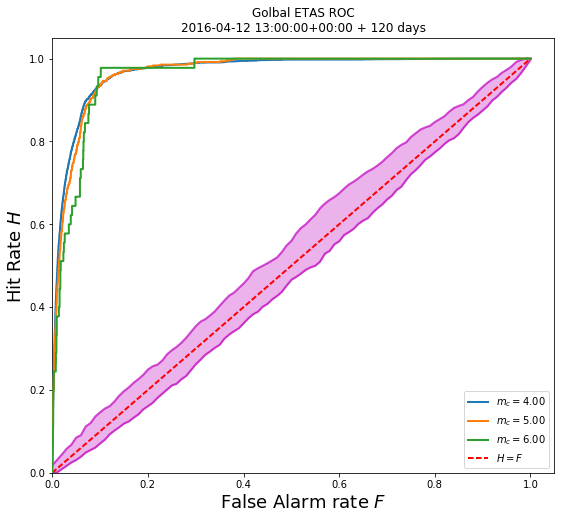

In [61]:
roc_glob = global_roc_from_optimizer(fc_xyz=xyz_output, fignum=0, mcs=[4.,5.,6.], fc_len=120, ls='-', 
                                                marker='', lw=2, etas_end_date=dtm.datetime(2016,4,12,13,
                                                                                            tzinfo=nepal_figs.pytz.timezone('UTC')))

# for global, this will be... HUGE, >600MB. the binary .pkl object (see below) is 500 MB.
# for publication, we can share an interpolated copy.
#with open(os.path.join(figs_data_path, 'global_roc_FH.json'), 'w') as f:
#    json.dump(roc_glob, f)

In [65]:
import pickle

with open(os.path.join(figs_data_path, 'global_roc_FH.pkl'), 'wb') as f:
    pickle.dump(roc_glob,f)

### ROC geospatial ranges

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2010-05-08 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.1000000000000001, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 288], None)
make_etas():
etas_mpp worker xyz_range:  [0, 1428]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


begin globalETAS.__init()__
fetch and process catalog for dates: [datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 9, 4, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.2000000000000002, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 9, 4, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 147], None)
etas_mpp worker xyz_range:  [0, 1428]
begin globalETAS.__init()__
ETAS over etas_cat_range/xyz_range:  ([0, 147], [0, 1428])
etas_mpp worker xyz_range:  [1428, 2857]
begin globalETAS.__init()__
ETAS over etas_cat_range/xyz_range:  ([0, 147], [1428, 2857])
etas_mpp worker xyz_range:  [2857, 4285]
begin globalETAS.__init()__


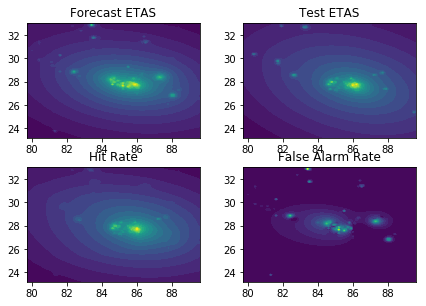

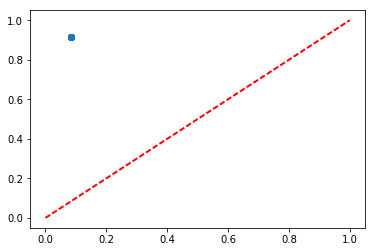

/home/myoder/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1035: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/myoder/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1045: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


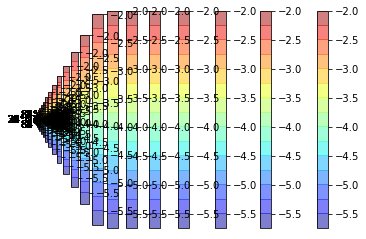

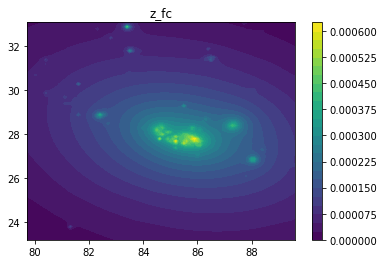

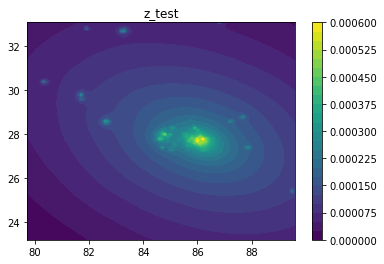

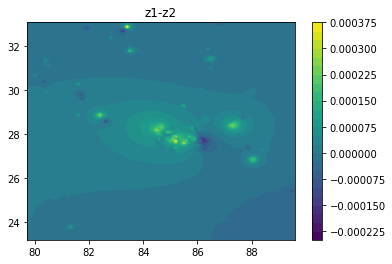

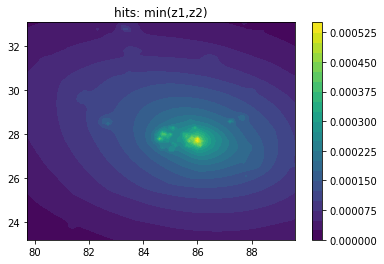

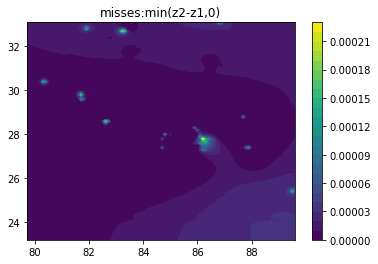

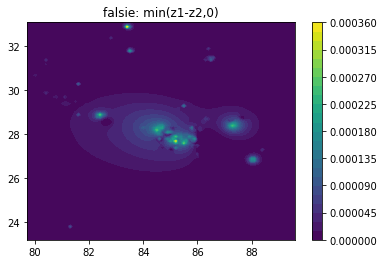

In [22]:
# first, get all the ROC geospatials...
# there is, i think, another version of this script that should be faster (same module).
# (this version takes about a day at 8 x 1.77GHz)
#
do_roc_gs_calcs = False
#do_roc_gs_calcs = True
#
#f_path  = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/revs_201703/gs_roc_q_v_q'
#f_path  = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/gs_roc_q_v_q'\
f_path  = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/debug/data_n_figs/gs_roc_q_v_q'
#pth,fname = os.path.split(f_pkl)
if not os.path.isdir(f_path): os.makedirs(f_path)
#
f_pkl   = os.path.join(f_path, 'etas_roc_geospatial_FHs.pkl')
f_json  = os.path.join(f_path, 'etas_roc_geospatial_FHs.json')
f_csv   = os.path.join(f_path, 'etas_roc_geospatial_FHs.csv')

if do_roc_gs_calcs:
    # we had taken these all the way out to 3.5, but this metric optimizes at the lower q's so let'
    # save ourselves some compute time...
    q_t_min  = 1.1
    q_fc_min = 1.1
    q_t_max  = 2.5
    q_fc_max = 2.5
    #
    # note: for debugging, we might want to bump these up a bit...
    dq_fc = .1
    dq_t  = .1
    aa=nepal_figs.etas_roc_geospatial_raw(q_t_min=q_t_min, q_t_max=q_t_max, q_fc_min=q_fc_min, q_fc_max=q_fc_max,
                                   dq_fc=dq_fc, dq_t=dq_t, fignum=0, fout=f_csv)
    #aa=etas_analyzer.etas_roc_geospatial_raw(q_t_min=1.1, q_t_max=2.5, q_fc_min=1.1, q_fc_max=2.5,
    #                               dq_fc=.5, dq_t=.5, fignum=0, fout=f_csv)
    #
    plt.figure(0)
    plt.plot(range(2), range(2), ls='--', lw=2., color='r')
    #
    for j in list(range(0,8))+[42]:
        # getting somethien weird for fig. need to figure out what fig1 is and why it's acting weird...
        if j==1: continue
        plt.figure(j)
        plt.savefig(os.path.join(f_path, 'etas_roc_geospatial_raw_output_fig_{}.png'.format(j)))
    #
    # dump/save the data    
    #
    with open(f_pkl, 'wb') as fout:
        pickle.dump(aa,fout)

    # turns out these data sets aren't that big:
    with open(f_json, 'w') as fout:
        json.dump(aa,fout)
#######
# split here...
######

   

In [24]:
type(aa)

list

loading roc_gs from: /home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/revs_201703/gs_roc_q_v_q/etas_roc_geospatial_FHs.json


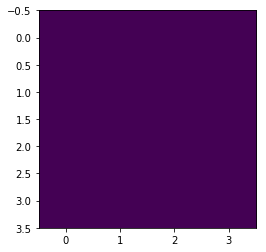

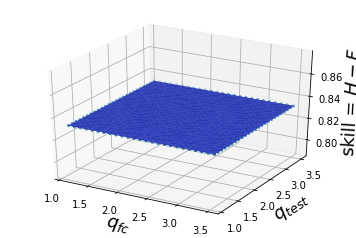

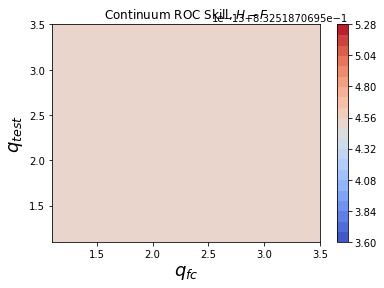

In [27]:
 

#f_path = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/gs_roc_q_v_q'
#f_json_dbg = '/home/myoder/Dropbox/Research/globalETAS/nepal_etas/debug/data_n_figs/gs_roc_q_v_q/etas_roc_geospatial_FHs.json'
#roc_gs_datas = json.load(open(f_json_dbg))
roc_gs_datas = json.load(open(f_json))
#
#print('loading roc_gs from: {}'.format(f_json))

#print(roc_gs_datas[0:3])
# eventually, start using this script (again); adapt it to accept either a tabular csv or a .json.
# q_q_skill_figs(data='data/roc_geospatial_nepal_q11_24_11_24.csv')

Xs=sorted(list(set([x for x,y,f,h in roc_gs_datas])))
Ys=sorted(list(set([y for x,y,f,h in roc_gs_datas])))
Zs=numpy.array(list([h-f for x,y,f,h in roc_gs_datas]))
#
Zs.shape=(len(Ys), len(Xs))
#
plt.imshow(Zs.transpose())



cc=nepal_figs.q_q_skill_figs(os.path.join(f_path, f_json), fignum=4)

### Gorkha ETAS with m>7 (like "regular" ETAS):


In [68]:
pram_updates   = {'mc':7., 'etas_range_factor':25, 'etas_range_padding':1.25 }
pram_updates_6 = {'mc':5.5, 'etas_range_factor':25, 'etas_range_padding':1.25 }
fc_gorkha_7 = etas_analyzer.get_nepal_etas_fc(n_procs=3, cat_len=30, p_cat=1.1, q_cat=1.5, 
                                    t_0 = dtm.datetime(2010,1,1, tzinfo=tz_utc), 
                                    t_now=dtm.datetime(2015,5,7, tzinfo=tzutc), **pram_updates)
fc_gorkha_6 = etas_analyzer.get_nepal_etas_fc(n_procs=3, cat_len=30, p_cat=1.1, q_cat=1.5, 
                                    t_0 = dtm.datetime(2010,1,1, tzinfo=tz_utc), 
                                    t_now=dtm.datetime(2015,5,7, tzinfo=tzutc), **pram_updates_6)

#

begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (30.000000) = 2015-04-07 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2015, 4, 7, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2015, 4, 7, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'mc': 7.0, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 1428]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


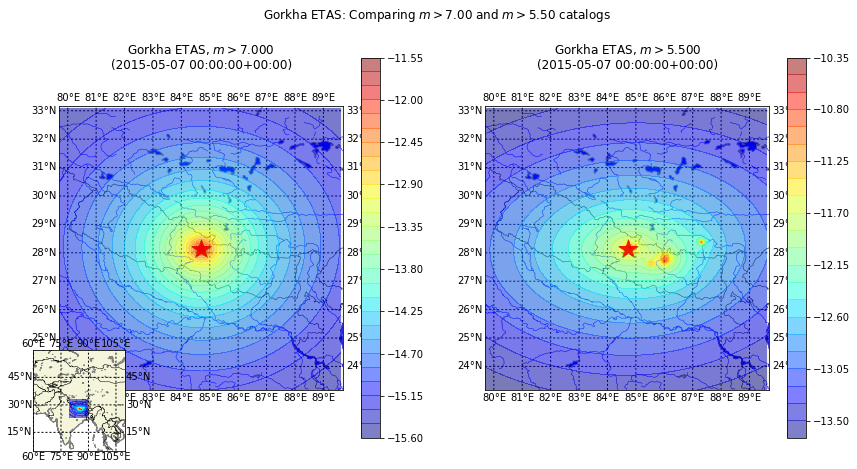

In [69]:
fg=plt.figure(0, figsize=(14,7))
ax1 = plt.subplot('121')
ax2 = plt.subplot('122')
fc_gorkha_7.plot_mainshock_and_aftershocks(ax=ax1)
fc_gorkha_6.plot_mainshock_and_aftershocks(ax=ax2)
ax1.set_title('Gorkha ETAS, $m>{:.3f}$\n({})\n\n'.format(pram_updates['mc'], fc_gorkha_7.t_now))
ax2.set_title('Gorkha ETAS, $m>{:.3f}$\n({})\n\n'.format(pram_updates_6['mc'], fc_gorkha_7.t_now))
plt.suptitle('Gorkha ETAS: Comparing $m>{:.2f}$ and $m>{:.2f}$ catalogs'.format(pram_updates['mc'], pram_updates_6['mc']))
fg.savefig(os.path.join(revisions_data, 'nepal_fc_etas_m7_m6_contours.png'))
#
# draw an inset to show location:
ax_inset = fg.add_axes([.01, .1, .27, .2])
cm_fc = neapl_etas_initial.make_etas_contour_map(ax=ax_inset, fig_size=(10,8), n_contours=25, lons_map=(60,110),
                                                 lats_map=(5,60), lon_interval=15, lat_interval=15, do_colorbar=False,
                                                do_states=False, do_rivers=False, lake_color=None)


#cc=nepal_figs.q_q_skill_figs(os.path.join(figs_data_path, f_json), fignum=4)
fname_cat_6_7 = os.path.join(figs_data_path, 'gorkha_etas_m7_m6_comparison.png')
plt.savefig(fname_cat_6_7)
fname_cat_6_7 = os.path.join(revisions_data, 'gorkha_etas_m7_m6_comparison.png')
plt.savefig(fname_cat_6_7)

In [70]:
#plt.savefig(fname_cat_6_7)

In [71]:
print(revisions_data)

data/revisions_outputs


### Rotation validation and composite demo

etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 2.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7fa671e381d0>), datetime.datetime(2017, 3, 8, 5, 1, 3, 148955, tzinfo=<UTC>)], 'mc': 2.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-03-07 03:07:55.036077+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 128]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-03-07 03:07:55.036077+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 128])
etas_mpp worker xyz_range:  [128, 257]
beg

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 2.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(1990, 1, 1, 0, 0, tzinfo=<matplotlib.dates._UTC object at 0x7fa671e381d0>), datetime.datetime(2017, 3, 8, 5, 1, 3, 148955, tzinfo=<UTC>)], 'mc': 2.5, 'lons': [-117.0, -114.0], 'lats': [32.0, 38.0], 'incat': None}
results fetched.
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-03-07 03:07:55.036077+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], None)
make_etas():
etas_mpp worker xyz_range:  [0, 128]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2012-03-07 03:07:55.036077+00:00
ETAS over etas_cat_range/xyz_range:  ([0, 1], [0, 128])
etas_mpp worker xyz_range:  [128, 257]
beg

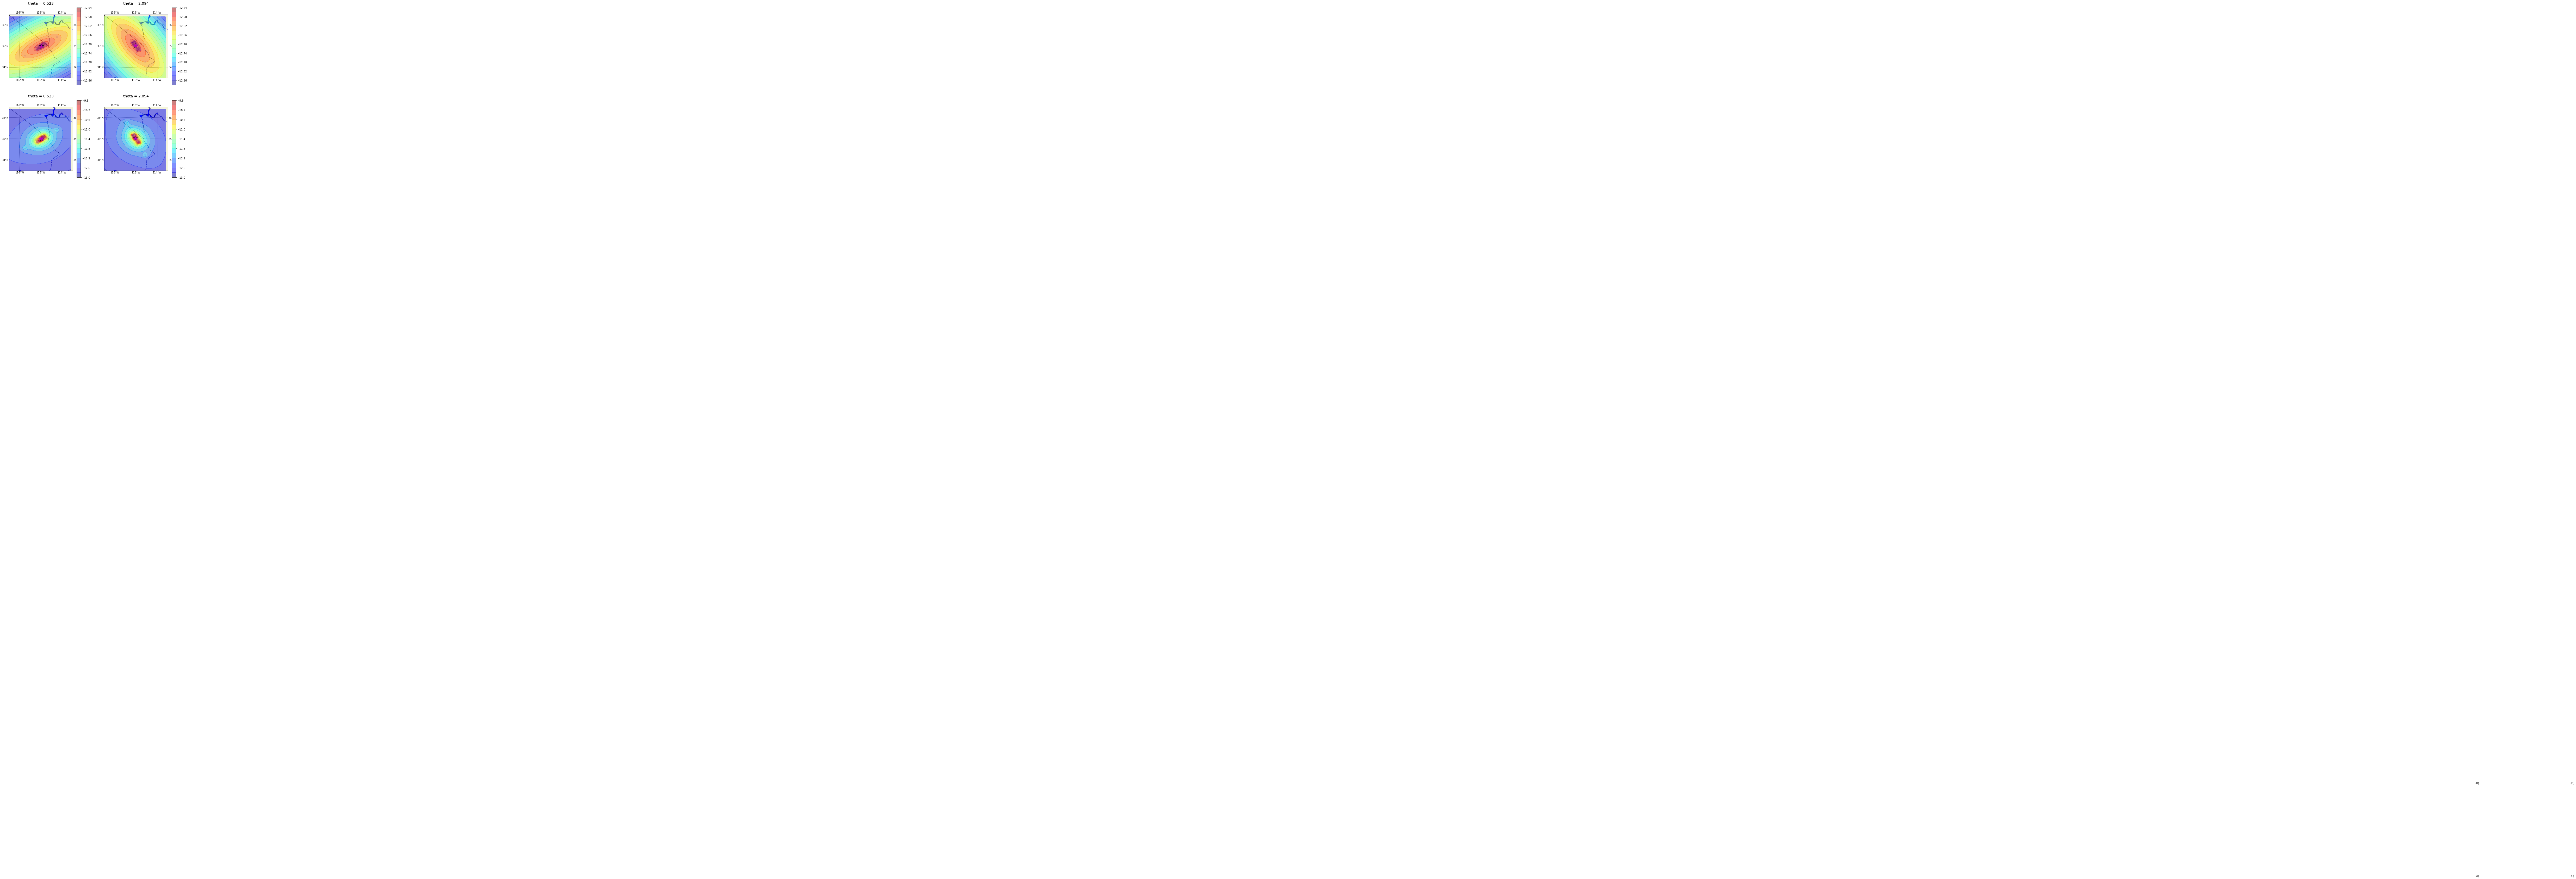

In [72]:
# make a toy catalog:
#N_ev=20, theta=3.14/4., m0=7., dm=3., lat0=35., lon0=-115., delta_t=2., t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
N_ev=120
#theta=(1./6.)*3.14
m0=7.
dm=3.
lat0=35.
lon0=-115.
delta_t=2.
t0=dtm.datetime(2016,1,1, tzinfo=tzutc)
#
L_r = 10.**(.5*m0 - 1.76)
L = 3.5*L_r
#print('**L,L_r = ', L, L_r)
d_LL = L/111.1
y_scatter = 0.45
ab_ratio_expon=.5
#
R = random.Random()
r_factor=.2
km2_ll = 1./111.
m = m0-dm
m_ms = m0
#
#d_lat = km2_ll*L*math.sin(theta)/N_ev
#d_lon = km2_ll*L*math.cos(theta)/(N_ev*math.cos(lat0))
dt = dtm.timedelta(days=delta_t)
dy0=0.
#

fg=plt.figure(figsize=(12,12))
plt.clf()
#ax=plt.gca()
n_rw=2
n_cl=2
#
d_lat=1.5
d_lon=1.5
mylats = [lat0-d_lat, lat0+d_lat]
mylons = [lon0-d_lon, lon0+d_lon] 
#
letter_labels = ['(A)', '(B)', '(C)', '(D)']
#
for k,theta in enumerate([(x/6.)*3.141 for x in [1.,4.]]):
    #
    LLs = [[-.5*L/111.1,dy0], [.5*L/111.1, dy0]]
    LLs = numpy.array(LLs + [[(R.random()-.5)*L_r/(111.1*math.cos(lat0)), dy0 + (R.random()-.5)*y_scatter*L_r/111.1] for j in range(N_ev)])
    #
    M_r = numpy.array([[math.cos(theta), -math.sin(theta)], [math.sin(theta), math.cos(theta)]]).T
    #
    LLs = numpy.dot(LLs, M_r)
    #
    cat = []
    #
    for j, (lon,lat) in enumerate(LLs):
        cat += [[t0+dt*j, lon+lon0, lat+lat0, m, mpd.date2num(t0+dt*j) ]]
    #
    tms = cat[int(.5*len(cat))][0]
    #cat += [[cat[-1][0]+dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
    #        mpd.date2num(cat[-1][0]+dt) ]]
    # add a mainshock:
    ms_lon, ms_lat = numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat])
    #cat += [[tms+.5*dt, numpy.mean([rw[1] for rw in cat]), numpy.mean([rw[2] for rw in cat]), m_ms,
    cat += [[tms+.5*dt, ms_lon, ms_lat, m_ms, mpd.date2num(tms+.5*dt) ]]
    #
    #
    cat = numpy.core.records.fromarrays(zip(*cat), dtype = [('event_date', 'datetime64[us]'),
                                                                    ('lon', '>f8'), ('lat', '>f8'), ('mag', '>f8'),
                                                                   ('event_date_float', '>f8')])
    cat_original = cat.copy()
    #
    ######################################
    ######################################
    #
    gep_cat = cat_original.copy()
    # add a mainshock (assign a large magnidute to the middle event):
    #gep_cat[int(len(gep_cat)/2)]['mag'] +=3.
    gep_cat = gep.make_ETAS_catalog_mpp(incat=gep_cat, fit_factor=2.5)
    #
    # get just the mainshock:
    max_mag = max(gep_cat['mag'])
    rw = gep_cat[0]
    for rw in gep_cat:
        if rw['mag']>=max_mag:
            ms_cat = numpy.array([rw], dtype=gep_cat.dtype)
            mainshock = rw
            break
    #
    ax1 = plt.subplot('{}{}{}'.format(n_rw, n_cl, k+3))
    ax2 = plt.subplot('{}{}{}'.format(n_rw, n_cl, k+1))
    #
    ms_etas1 = gep.ETAS_mpp(catalog=ms_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon, ab_ratio_max=2.)
    ms_etas = gep.ETAS_mpp(catalog=gep_cat, lats=mylats, lons=mylons, ab_ratio_expon=ab_ratio_expon, ab_ratio_max=2.)
    #print('***Debug: lats_lons::  ', mylats, mylons)
    #
    ms_etas.make_etas_contour_map(ax=ax1, lats_map=mylats, lons_map=mylons)
    ms_etas1.make_etas_contour_map(ax=ax2, lats_map=mylats, lons_map=mylons)
    #
    #new_etas.cm.scatter(*zip(*xy_prime), 'o', edgecolors='b', c='none', s=18)
    #new_etas.cm.plot(gep_cat['lon'], gep_cat['lat'], marker='o', color='b', zorder=7, latlon=True)

    #plt.figure()
    ax1.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)
    ax1.plot([ms_lon], [ms_lat], marker='*', color='k', ms=18, zorder=11)
    ax1.plot([ms_lon], [ms_lat], marker='*', color='m', ms=16, zorder=11)
    ax2.plot(gep_cat['lon'], gep_cat['lat'], marker='o', ls='', color='b', zorder=7, alpha=.1)
    ax2.plot([ms_lon], [ms_lat], marker='*', color='k', ms=18, zorder=11)
    ax2.plot([ms_lon], [ms_lat], marker='*', color='m', ms=16, zorder=11)
    #
    ax1.set_title('theta = {:.3f}\n\n'.format(theta), size=14)
    ax2.set_title('theta = {:.3f}\n\n'.format(theta), size=14)
    #
    ax1.text(.1,.1, letter_labels[2*k])
    ax2.text(.1,.1, letter_labels[2*k+1])
#fg.set_figheight(12)
#fg.set_figwidth(12)

fg.savefig('/home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/orientation_demo_quad.png')

working... (this might take a while)...
**DEBUG lons:  [-123.0, -90.2] (-180.0, 179.9) [30.0, 45.0]
**DEBUG lons:  [30.0, 45.0] (-89.0, 88.9) [30.0, 45.0]


/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


cmap:  jet
working file: /home/myoder/Dropbox/Research/globalETAS/nepal_etas/data_n_figs/global_etas.xyz
hd:  {'lons': '[-180.0, 180.0]', 'mc': '3.0', 'd_lon': '0.1', 'd_lat': '0.1', 'etas_range_factor': '30.0', 'etas_range_padding': '1.0', 'etas_fit_factor': '1.5', 't_now': '2016-04-12 12:52:59+00:00', 'cat_len': '3650.0'}
finishd.


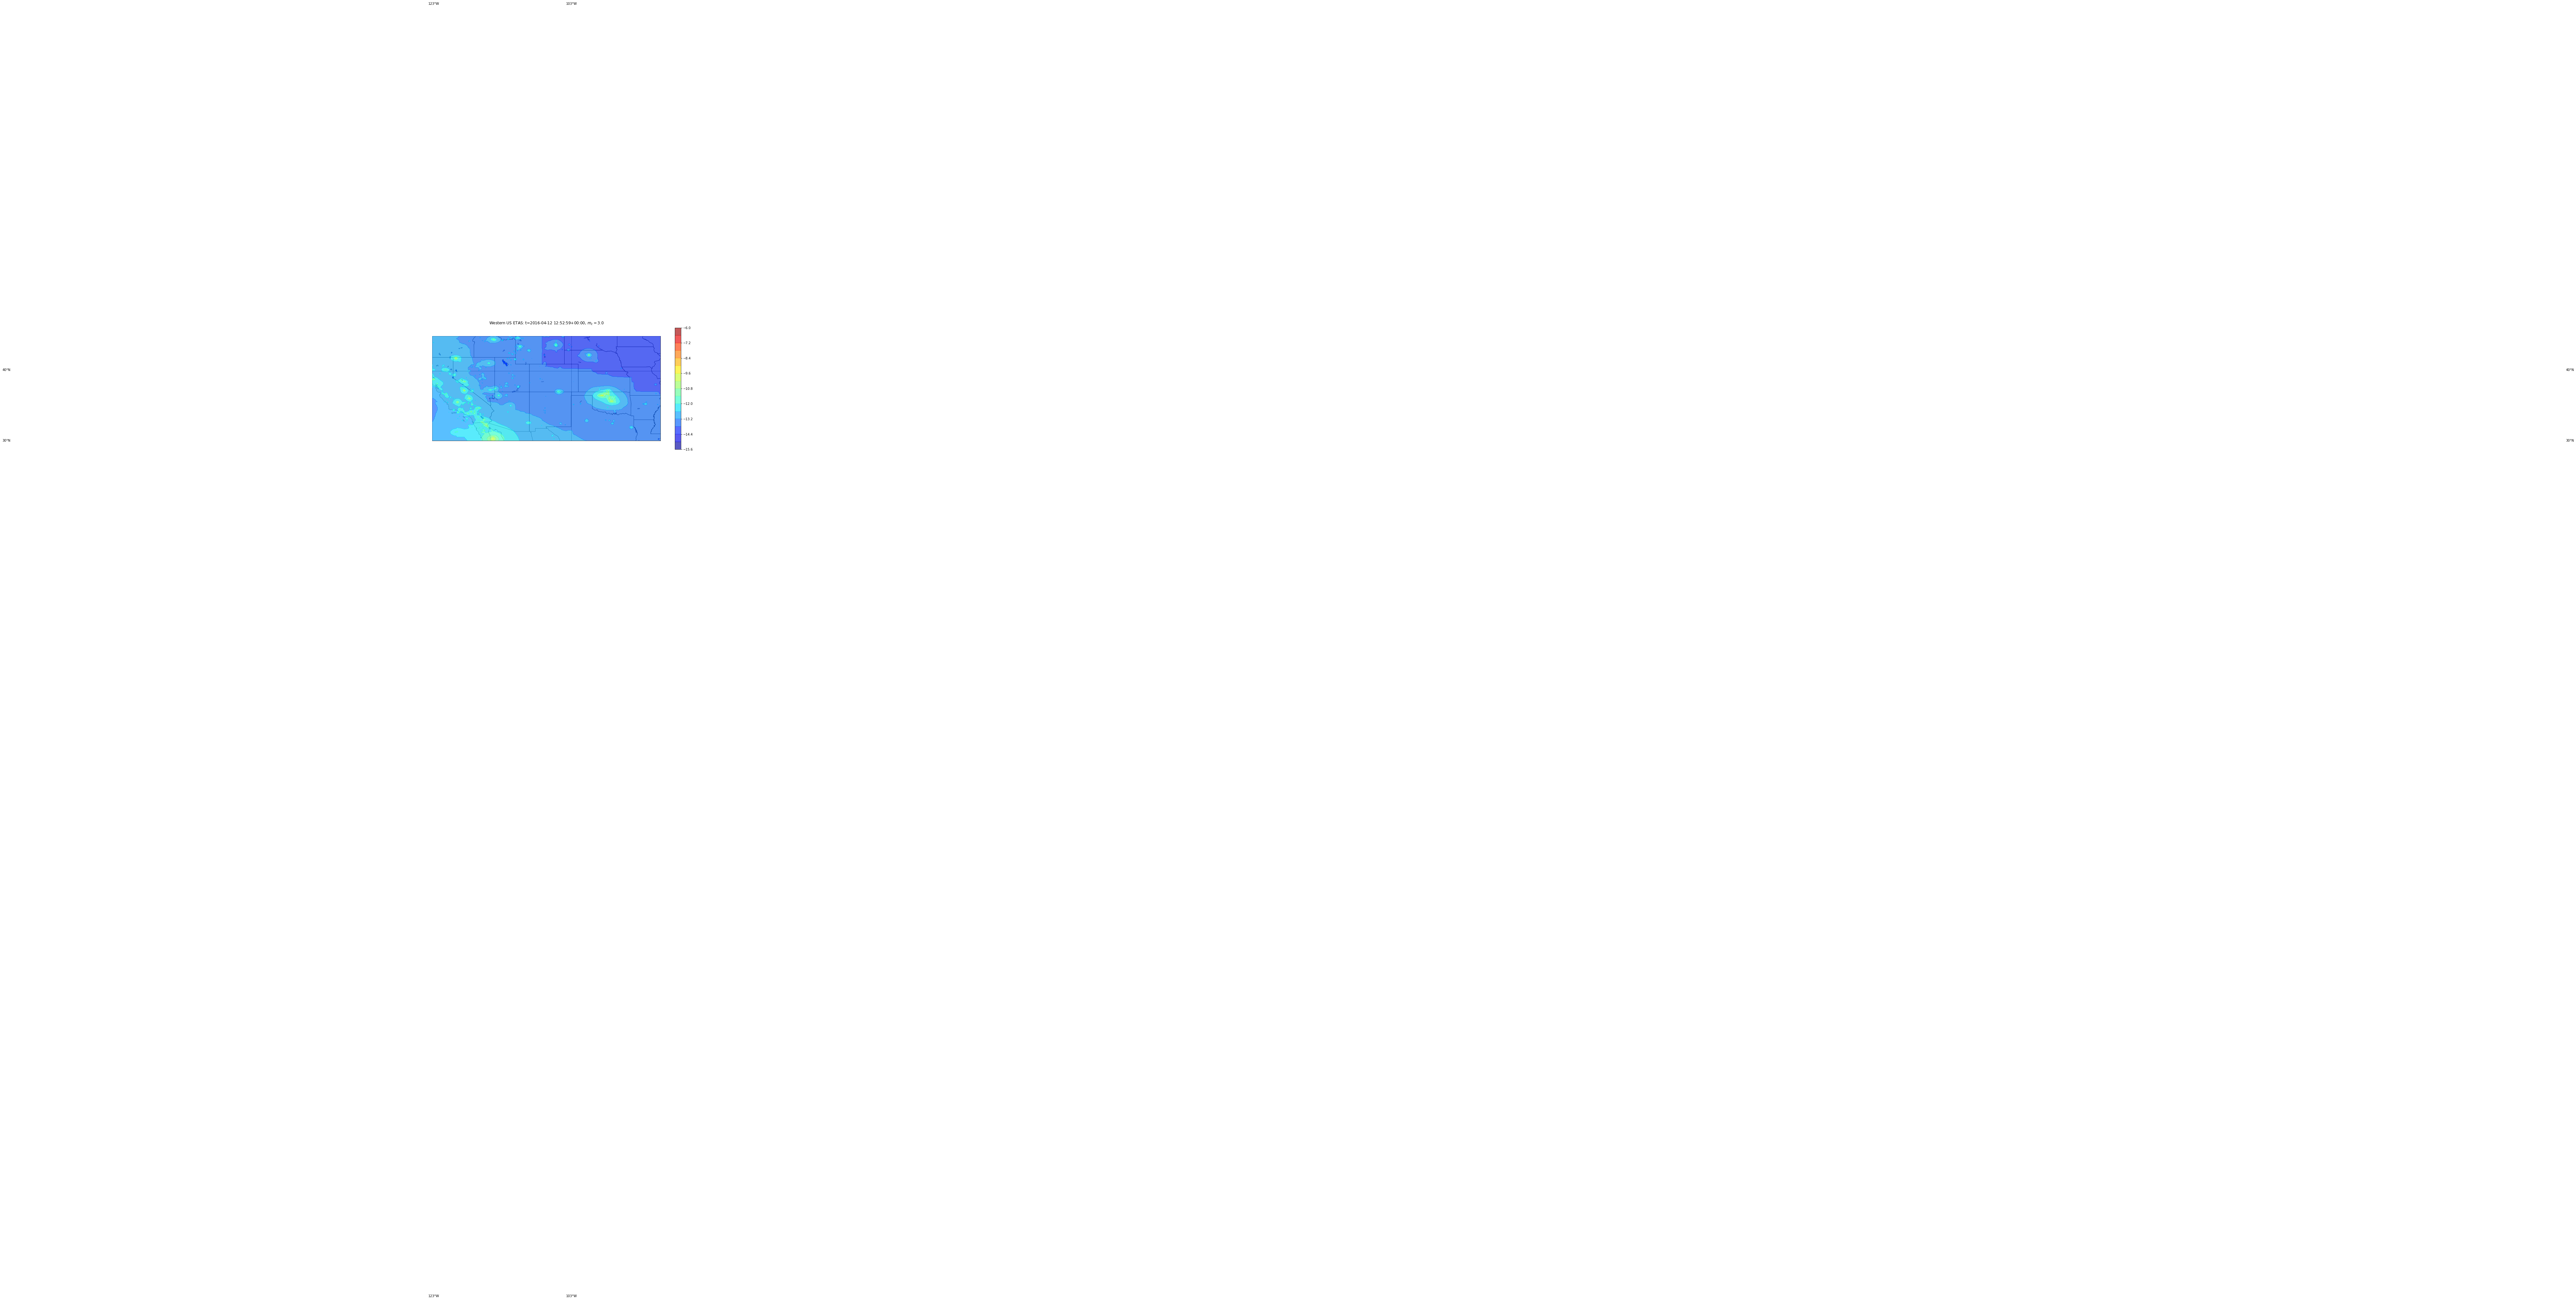

In [78]:
###
# let's get an OK (western US) from our new global ETAS:
plt.figure(0, figsize=(16,14))
print('working... (this might take a while)...')
# nepal_figs.
# rewrite or modify this to draw a map over a smaller spatial domain:
# from nepal_figs:
#mm = Map_drawer(xyz=xyz_output, map_lats=[30., 45.], map_lons=[-123., -90.2])
cmap_str = 'jet'
#cmap_str = 'spectral'
map_lons=[-123., -90.2]
map_lats=[30., 45.]
CC = draw_global_etas_contours(xyz=xyz_output, map_lats=map_lats, map_lons=map_lons, 
                               fignum=0, cmap=cmap_str, do_colorbar=False)
#ax = plt.gca()
#ax.set_ylim(map_lats)
#ax.set_xlim(map_lons)
plt.colorbar(shrink=.5)
#
print('working file: {}'.format(xyz_output))
#
# get header data:
header_data=''
with open(xyz_output, 'r') as fin:
    for rw in fin:
        if rw.startswith('#'):
            #rw.replace('\n', '\t')
            header_data = header_data + rw.replace('\n', '\t')[1:]
        else:
            break
    #header_data = header_data + fin.readline()
#
header_datas = header_data.split('\t')
#header_datas = {key:val for key,val in rw.split('=') for rw in header_datas}
header_datas = dict([rw.split('=') for rw in header_datas[2:] if len(rw.split('='))>=2])
plt.title('Western US ETAS: t={}, $m_c={:.1f}$\n\n'.format(header_datas['t_now'], float(header_datas['mc'])))
#
plt.savefig(os.path.join(revisions_data, 'US_west_etas_map_{}.png'.format(cmap_str)))

print('hd: ', header_datas)
          
print('finishd.')
#


begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catlen (1825.000000) = 2010-05-08 00:00:00+00:00
fetch and process catalog for dates: [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)]
etas_prams:  {'do_recarray': False, 'b2': 1.5, 'b1': 1.0, 'dmstar': 1.0, 'q': 1.5, 'p': 1.1, 'fit_factor': 1.5, 'd_tau': 2.28, 'd_lambda': 1.76, 'D_fract': 1.5, 'date_range': [datetime.datetime(2010, 5, 8, 0, 0, tzinfo=<UTC>), datetime.datetime(2015, 5, 7, 0, 0, tzinfo=<UTC>)], 'mc': 3.5, 'lons': [79.698, 89.698], 'lats': [23.175, 33.175], 'incat': None}
data handle fetched...
 no file.
results fetched.
catalog fetched and processed.
ETAS over etas_cat_range/xyz_range:  ([0, 288], None)
make_etas():
etas_mpp worker xyz_range:  [0, 1428]
begin globalETAS.__init()__
Overriding t_0 (etas catalog start date/time) for ETAS calculations. using catalog start, t_0 = t_now - catl

/home/myoder/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()


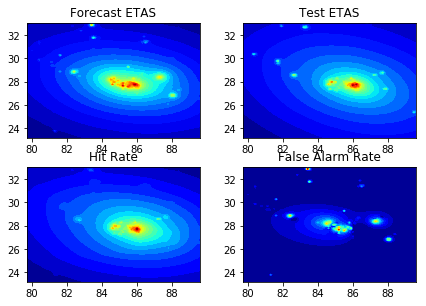

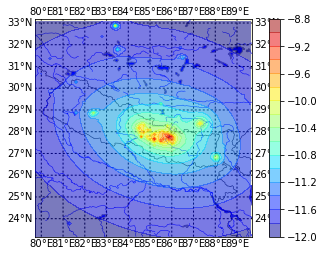

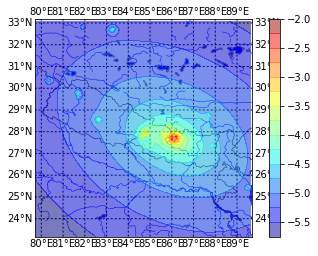

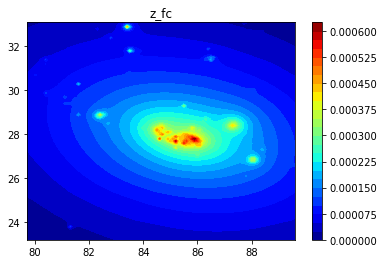

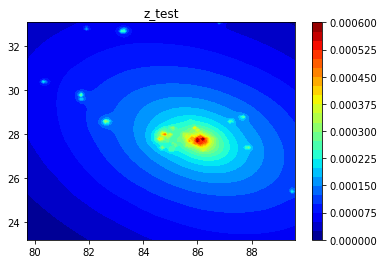

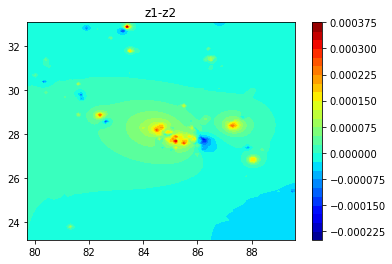

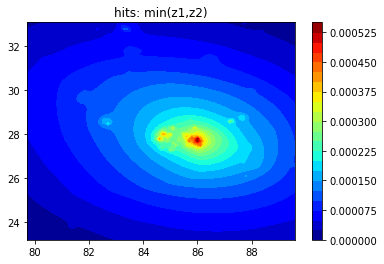

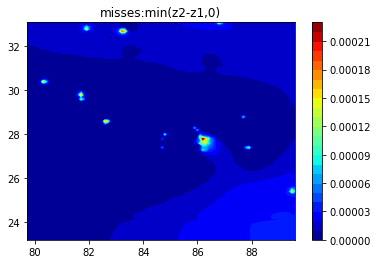

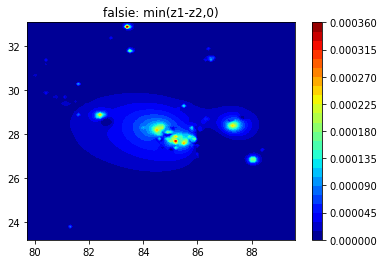

In [83]:
# and get the gs_roc_quad separately (because the full script bit is a huge pain):
gs_etas = etas_analyzer.analyze_etas_roc_geospatial(etas_fc=None, etas_test=None, do_log=True, diagnostic=False)
#

plt.figure(42)
plt.savefig(os.path.join(revisions_data, 'geospatial_ROC_quad_{}.png'.format(cmap_str)))